# Breast Cancer Classification Model

## Problem Definition

The Breast Cancer is a universal major health issue which could be improved with early diagnosis which could potentially lead to a more effective treatment plan. 

The primary goal of this project is to develop a machine learning model that can accurately classify a breast tumor as either benign or malignant. This classification will be based on different features extracted from digitized images of a breast mass.

Reference:

*[1] Wolberg,William, Mangasarian,Olvi, Street,Nick, and Street,W.. (1995). Breast Cancer Wisconsin (Diagnostic). UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.*


## Dataset Exploration

### Wisconsin Diagnostic Breast Cancer Dataset

The Wisconsin Diagnostic Breast Cancer dataset describes the measurements on cells in suspicious lumps in a women's breast. This dataset, obtained from the University of Wisconsin Hospitals, includes 30 feature variables and 1 target variable. 

The features, or input attributes, are numeric, and a binary target variable: M for Malignant and B for benign.

Each cell-nucleus include 10 actual features:

- Radius (mean of distances from center to points on the perimeter)
- Texture (standard deviation of gray-scale values)
- Perimeter
- Area
- Smoothness (local variation in radius lengths)
- Compactness (perimeter^2 / area - 1.0)
- Concavity (severity of concave portions of the contour)
- Concave points (number of concave portions of the contour)
- Symmetry 
- Fractal dimension ("coastline approximation" - 1)

Now, the dataset will be loaded to check the data in detail. To accomplish this, the required libraries and packages will be installed.

A virtual environment will be instantiated and activated, which will help in isolating dependencies and avoiding conflicts.

In [ ]:
!python -m venv myenv
!.\myenv\Scripts\activate
!code .

The Jupyter Notebook Kernel will need to be switched to the newly created environment using the Jupyter Notebook interface, and then all the required libraries will be installed.

In [ ]:
!pip3 install ipykernel matplotlib pandas numpy seaborn scikit-learn tensorflow scikeras

In [ ]:
!pip3 install -U ucimlrepo

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

data_combined = pd.concat([X, y], axis=1)
  
# metadata 
#print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
#print(breast_cancer_wisconsin_diagnostic.variables)

A data preview will be retrieved to allow for an initial examination of the dataset.

In [ ]:
# Print the first few rows of the data
print("\nFirst few rows of Features and Target combined")
print(data_combined.head())

### The dimensionality of the dataset

It can be observed that access to the repository from UCIML has been successfully established and the data has been loaded. 

Next, the dimensionality of the dataset needs to be understood in terms of the number of rows and columns (features and target variable).

In [ ]:
# Print the shape of the data

print("Shape of X (features):", X.shape)
print("Shape of y (targets):", y.shape)

### Statistical Summary

The statistical properties of each attribute will be retrieved to gain insights into the dataset.

In [ ]:
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)

descriptionDataCombined = data_combined.describe()

print(descriptionDataCombined)

### Class Distribution

As this is a classification problem, the data will be analyzed to determine the number of observations for each class. If the classes are highly imbalanced, further actions will need to be taken during data pre-processing.

In [ ]:
class_counts = data_combined.groupby('Diagnosis').size()
print(class_counts)

total = class_counts.sum()
proportion_B = class_counts['B'] / total
proportion_M = class_counts['M'] / total

print(f"\nProportion of class B: {proportion_B:.2f}")
print(f"Proportion of class M: {proportion_M:.2f}")

### Features Correlation 

By calculating the correlation between the different variables, it will be possible to analyze if they are tightly coupled (highly correlated). This is important as it can affect the performance of the machine learning algorithms.

The Pearson's Correlation Coefficient will be calculated, assuming a normal distribution in the attributes. Before doing so, the target variable needs to be converted to a numeric one.

In [ ]:
# Convert the Diagnosis column from string to numerical values.
data_combined['Diagnosis'] = data_combined['Diagnosis'].map({'M': 1, 'B': 0})

# Calculate the Pearson's Correlation Coefficient
correlations = data_combined.corr(method='pearson')
print(correlations)

Due to the large size of the table, variables that are highly correlated (greater than 0.75) will be retrieved by sorting and printing them.

In [ ]:
# Unstack the correlation matrix
correlation_pairs = correlations.unstack()

# Sort the correlation pairs
sorted_pairs = correlation_pairs.sort_values(kind="quicksort", ascending=False)

# Retrieve high correlations and exclude self-correlations, as they aren't relevant.
high_correlations = sorted_pairs[(sorted_pairs != 1.0) & (sorted_pairs.abs() > 0.75)]

print(high_correlations)

A correlation matrix will be plotted to achieve a better understanding of the data correlation [1].

References:

*[2] A. Ashfaq, "Plot correlation matrix using pandas," Stack Overflow, Apr. 8, 2015. [Online]. Available: [Stack Overflow](https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas)*

In [ ]:
# Plotting the Correlation Matrix

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.index)), correlations.index)
plt.show()

The correlation matrix shows a highly correlated variables are the radius and perimeter. This makes sense due to its mathematical relationship, as the radius is directly proportional to the perimeter.

### Skew of Univariate Distributions

Now, an analysis of the attributes will be carried out to identify if there is any attribute with a skew, in order to consider it during the data preparation phase.

In [ ]:
skew = data_combined.skew()

sorted_skew = skew.sort_values(ascending=False)

negative_skew = sorted_skew[sorted_skew < 0]
positive_skew = sorted_skew[sorted_skew > 0]
higher_skew = sorted_skew[sorted_skew > 1]

print("\nNegative Skew\n")
print(negative_skew)

print("\nPositive Skew\n")
print(positive_skew)

print("\nHigher Skew\n")
print(higher_skew)

The skew results show there is no negative skew as all attribute values are positive. Additionally, it can be observed that some features have a higher skew than the rest of the features, with values greater than 3. 

Histograms of each attribute will now be plotted to check their distribution.

In [ ]:
# Univariate Histograms
data_combined.hist(figsize=[20, 20])
plt.show()

## Data Transformation

As it is described in the dataset information, there are no missing values in features and the target so no major transformations are deemed necessary for the data, except for transforming the target column to a numeric format, as some models require a numeric target variable.

In terms of data scaling, the data will be standardized. Models such as Logistic Regression, SVM, k-Nearest Neighbors, and Neural Networks utilize optimization algorithms that perform better when the data is standardized.

Additionally, a feature selection technique will be implemented in the next steps, which also requires standardization to ensure that all features are treated equally.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Target variable transformation
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y.squeeze())

# Print the transformed target variable to check if we have transformed it correctly
print("Transformed Target Variables (First 10 elements):", y_numeric[:10])

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Feature Engineering

### Feature Selection

As the data set includes several features related to the same mass area, a feature importance will be applied to understand which specific features are most important for prediction in improve the model interpreatibiltiy by simplifying it.

In this case feature importance will be applied using the Ensemble method Random Forest Classifier and Train Test Split resampling method. Features will be filtered based on their score.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

num_folds = 10
seed = 7

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.3, random_state=42)

importances = np.zeros(X_scaled.shape[1])

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Select top features (e.g., those with importance > 0.01)
top_features = feature_importance_df[feature_importance_df['Importance'] > 0.01]['Feature']
X_top = X[top_features]

# Print the important features
print("Selected Important Features:")
print(top_features)

The feature importance plot shows that the most important features are related to the shape and size of the mass, such as area, concavity and permiter.

Some measurements suggests that there is some redundancy in the the features dataset.

Other features such as texture, compactness or smoothness provide less information for the classification problem.

### Dimensionality Reduction

#### Principal Component Analysis (PCA)

As a preprocessing step, and in order to exclude irrelevant or redundant features, dimensionality reduction will be carried out using the Principal Component Analysis (PCA) technique. This will allow the capture of the maximum variance in the dataset with a fewer number of components.

The feature importance will be also considered in this step.

Reference:

*[3] "Principal Component Analysis with Python," GeeksforGeeks, 2024. [Online]. Available: https://www.geeksforgeeks.org/principal-component-analysis-with-python/*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score

# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

# Convert target variable to numerical values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y.squeeze())

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.3, random_state=42)

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top features (e.g., those with importance > 0.01)
top_features = feature_importance_df[feature_importance_df['Importance'] > 0.01]['Feature']
X_top = pd.DataFrame(X_scaled, columns=feature_names)[top_features]


# Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Check the shape of the transformed data
print("Shape of X_pca:", X_train_pca.shape)

# Print the explained variance ratio of each principal component
print("Explained variance ratio of each principal component:")
for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Principal Component {i+1}: {variance_ratio:.4f}")

# Print the total explained variance
total_explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total explained variance: {total_explained_variance:.4f}")


It can be observed that Principal Components 1 have significantly higher variance ratios compared to the rest, making them more important in capturing the variance of the dataset.

Logistic Regression model will be trained and evaluated using only the first 5 principal components.



In [ ]:
# Logistic Regression with the first 5 principal components
X_train_pca_5 = X_train_pca[:, :5]  # Use the first 5 PCs
X_test_pca_5 = X_test_pca[:, :5]

model = LogisticRegression(solver='liblinear')
model.fit(X_train_pca_5, y_train)
y_pred_pca_5 = model.predict(X_test_pca_5)
accuracy_pca_5 = accuracy_score(y_test, y_pred_pca_5)
print(f"Accuracy with the first 5 PCs: {accuracy_pca_5:.4f}")

The model's performance remains high with an accuracy of approximately 0.98 using only the first 5 principal components. This indicates that the additional principal components are not necessary for solving the classification task effectively.

## Model Evaluation

Since the transformed dataset with the selected components is already stored in the variable X_PCA, the resampling method K-Fold Cross-Validation will be performed to evaluate how well the different models perform with data that haven't been used to train them.

### Model Performance Estimation

The goal is to compare and select the best model based on its performance estimation across multiple folds.

The performance of the different machine learning algorithms will be estimated using K-Fold Cross-Validation:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- Support Vector Machine
- k-Nearest Neighbors
- Neural Network

All of them are *Supervised Learning Models* since the data is labeled. Supervised learning is appropriate for classification tasks, which is the focus of this project. The aim is to train the models to accurately classify new data by learning patterns from the labeled training data.

The models will learn based on the input features and the output label (benign or malignant). This training process will eventually enable the models to make accurate predictions on unseen data.

In [ ]:
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

num_folds = 10
seed = 7

# Standardize and PCA transformation in pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
])

X_pca = pipeline.fit_transform(X_scaled)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear')))
models.append(('Decission Tree Classifier', DecisionTreeClassifier()))
models.append(('Random Tree Classifier', RandomForestClassifier()))
models.append(('Support Vector Machine', SVC()))
models.append(('k-Nearest Neighbors', KNeighborsClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
seed = 7 

for name, model in models:
   kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
   cv_results = cross_val_score(model, X_pca, y_numeric, cv=kfold, scoring=scoring)
   results.append(cv_results)
   names.append(name)
   msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   print(msg)

# Plot the results
plt.figure(figsize=(12, 6))
plt.boxplot(results, tick_labels=names)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

Although all models perform very well on the dataset, Logistic Regression and SVM models have demonstrated the best scores.

Now, the performance of a Neural Network will be analyzed on the same dataset and with the same seed.
The model will include several Dense layers which will use two different activation functions:
- ReLU
- Sigmoid

*ReLU* will output the input directly if posistive, while *Sigmoid* squashes the input to a range between 0 and 1.

The selected loss function is *Binary Cross-Entropy* as it is suitable for a Binary classification problem. It will quantify the error between the predicted and actual values.

Reference:

*[4] "Keras Layers," Keras Documentation, 2024. [Online]. Available: https://keras.io/2.15/api/layers/*

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.regularizers import l2

import warnings

# Suppress all UserWarnings to improve readability
warnings.filterwarnings('ignore', category=UserWarning)


# Define a function to create the different Keras models
def create_model_1():
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='relu'))  # input_dim should be 10
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Added dropout layers to prevent overfitting
def create_model_2():
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='relu'))  # input_dim should be 10
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Added l2 regularization and dropout layers to prevent overfitting
def create_model_3():
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='relu',kernel_regularizer=l2(0.01))) # Added l2 regularization
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(10, activation='relu',kernel_regularizer=l2(0.01))) # Added l2 regularization
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

neural_network_models = []
neural_network_models.append(('Neural Network Model 1', KerasClassifier(build_fn=create_model_1, epochs=150, batch_size=10, verbose=0)))
neural_network_models.append(('Neural Network Model 2', KerasClassifier(build_fn=create_model_2, epochs=150, batch_size=10, verbose=0)))
neural_network_models.append(('Neural Network Model 3', KerasClassifier(build_fn=create_model_3, epochs=150, batch_size=10, verbose=0)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
seed = 7 

for name, model in neural_network_models:
   kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
   cv_results = cross_val_score(model, X_pca, y_numeric, cv=kfold, scoring=scoring)
   results.append(cv_results)
   names.append(name)
   msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   print(msg)

# Plot the results
plt.figure(figsize=(12, 6))
plt.boxplot(results, tick_labels=names)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In order to prevent overfitting, a dropout layer has been added. This layer will randomly set some of the neurons to zero during the training phase, with a 50% chance for each neuron to be dropped, to achieve generalization in the model.

Additionally, L2 regularization has been added to the dense layers to keep the weights small and reduce model complexity and overfitting.

After implementing additional layers, dropout, and L2 regularization, the accuracy of the neural network model has improved. The accuracy of the neural network model is now comparable to the other models.

The neural network model achieved an accuracy of approximately 0.98, which is similar to the accuracy achieved by the other models. This indicates that the neural network model is performing well on the breast cancer dataset.

Some overfitting is observed in the last model, as it performs better than the previous two models. This conclusion is based on independent testing, which shows a slight reduction in performance. However, further investigation is not pursued as it can be attributed to random variations due to how the cross-validation splits the data.


References:

*[5] R. Vij, "Combating Overfitting with Dropout Regularization," Towards Data Science, 27-Apr-2020. [Online]. Available: https://towardsdatascience.com/combating-overfitting-with-dropout-regularization-f721e8712fbe.*

*[6] J. Brownlee, "How to Reduce Overfitting in Deep Learning with Weight Regularization," Machine Learning Mastery, 25-Aug-2020. [Online]. Available: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/.*

### Pipelining and Data Leakage

Data leakage occurs when information from outside the training dataset is used to create the model. In order to avoid data leakages a pipeline is used to standardize the data and apply PCA before training the model. This pipelining has been used in previous steps as well.

The pipeline is then evaluated using k-Fold Cross-Validation. For each fold, the data pipeline (including Standarization and PCA) is fitted on the training data. Once this is done, fitted transformations are applied to the test data within the same fold.

The model training is then done on the transformed training data and the model evaluation on the transformed test data.

The goal is to ensure that the test data is never seen during the training and it is only used during the model evaluation.

Reference:

*[7] "Leakage (machine learning)," Wikipedia, 13-May-2024. [Online]. Available: https://en.wikipedia.org/wiki/Leakage_(machine_learning).*

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.preprocessing import LabelEncoder

# Suppress all UserWarnings to improve readability
warnings.filterwarnings('ignore', category=UserWarning)

# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

data_combined = pd.concat([X, y], axis=1)

# Convert target variable to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.squeeze())

# Define a function to create the different Keras models
def create_model_1():
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='relu'))  # input_dim should be 10
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Added dropout layers to prevent overfitting
def create_model_2():
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='relu'))  # input_dim should be 10
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Added l2 regularization and dropout layers to prevent overfitting
def create_model_3():
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='relu',kernel_regularizer=l2(0.01))) # Added l2 regularization
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(10, activation='relu',kernel_regularizer=l2(0.01))) # Added l2 regularization
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Number of folds and random seed
num_folds = 10
seed = 7

# Define the k-fold cross-validator
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Prepare models within pipelines to avoid data leakage
models = []
models.append(('Logistic Regression', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', LogisticRegression(solver='liblinear'))
])))
models.append(('Decision Tree Classifier', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', DecisionTreeClassifier())
])))
models.append(('Random Forest Classifier', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', RandomForestClassifier())
])))
models.append(('Support Vector Machine', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', SVC())
])))
models.append(('k-Nearest Neighbors', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', KNeighborsClassifier())
])))
models.append(('Neural Network 1', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', KerasClassifier(model=create_model_1, epochs=150, batch_size=10, verbose=0))
])))
models.append(('Neural Network 2', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', KerasClassifier(model=create_model_2, epochs=150, batch_size=10, verbose=0))
])))
models.append(('Neural Network 3', Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', KerasClassifier(model=create_model_3, epochs=150, batch_size=10, verbose=0))
])))

# Evaluate each model in turn using cross-validation
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Plot the results
plt.figure(figsize=(20, 6))
plt.boxplot(results, tick_labels=names)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Model': names,
    'Mean Accuracy': [result.mean() for result in results],
    'Standard Deviation': [result.std() for result in results]
})

# Display the DataFrame
print("\nModel Performance:")
print(results_df)

When using the first five PCA components, machine learning models tend to perform better. This improvement is not observed when all ten PCA components are used, making the additional components unnecessary for enhancing model performance. Although this finding is somewhat expected, it highlights the effectiveness of dimensionality reduction in optimizing models.

Both Logistic Regression and Neural Networks are effective for breast cancer classification.

## Model Selection

### Hyperparameter Tuning

Hyperparameter tuning is implemented for Logistic Regression and Neural Network 1 models so that the best configuration can be found and used for the final model.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
from sklearn.preprocessing import LabelEncoder

# Suppress all UserWarnings to improve readability
warnings.filterwarnings('ignore', category=UserWarning)

# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

# Convert target variable to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.squeeze())

# Define a function to create the Keras model
def create_model_1(optimizer='adam'):
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Number of folds and random seed
num_folds = 10
seed = 7

# Define the k-fold cross-validator
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Logistic Regression Pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Grid search for Logistic Regression
param_grid_lr = [
    {'classifier__solver': ['liblinear'], 'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.01, 0.1, 1.0, 10, 100]},
    {'classifier__solver': ['lbfgs', 'sag', 'newton-cg'], 'classifier__penalty': ['l2'], 'classifier__C': [0.01, 0.1, 1.0, 10, 100]},
    {'classifier__solver': ['saga'], 'classifier__penalty': ['l1', 'l2', 'elasticnet'], 'classifier__C': [0.01, 0.1, 1.0, 10, 100], 'classifier__l1_ratio': [0.5]}
]
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=kfold, scoring='accuracy')
grid_search_lr.fit(X, y)
best_lr = grid_search_lr.best_estimator_
print(f"Logistic Regression - Best hyperparameters: {grid_search_lr.best_params_}")
print(f"Logistic Regression - Best cross-validation accuracy: {grid_search_lr.best_score_:.4f}")

# Neural Network 1 Pipeline
pipeline_nn1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', KerasClassifier(model=create_model_1, epochs=150, batch_size=10, verbose=0))
])

# Grid search for Neural Network 1
param_grid_nn1 = {
    'classifier__optimizer': ['adam'],
    'classifier__batch_size': [10, 20],
    'classifier__epochs': [100, 150]
}

# Evaluate the grid search using cross-validation
grid_search_nn1 = GridSearchCV(pipeline_nn1, param_grid_nn1, cv=kfold, scoring='accuracy')
grid_search_nn1.fit(X, y)
best_nn1 = grid_search_nn1.best_estimator_
print(f"Neural Network 1 - Best hyperparameters: {grid_search_nn1.best_params_}")
print(f"Neural Network 1 - Best cross-validation accuracy:  {grid_search_nn1.best_score_:.4f}")


As the *Logistic Regression* model has the highest cross-validation accuracy, it will be used it to make predictions on the test set. 

On the other hand, Neural  Network model won't be used as it does require more computational resources and time to train and it provides the same or less  accuracy as the Logistic Regression model.

## Model Evaluation

### F1 Score and Confusion Matrix

A Confusion Matrix will be plotted and a classification report generated to get a final review of how the model actually performs with the data set in terms of precision and recall.

Additionally, the F1 Score will be calculated to retrieve a single metric that includes Precision and Recall.

Logistic Regression: 0.975439 (0.011637)
F1 Score: 0.9639


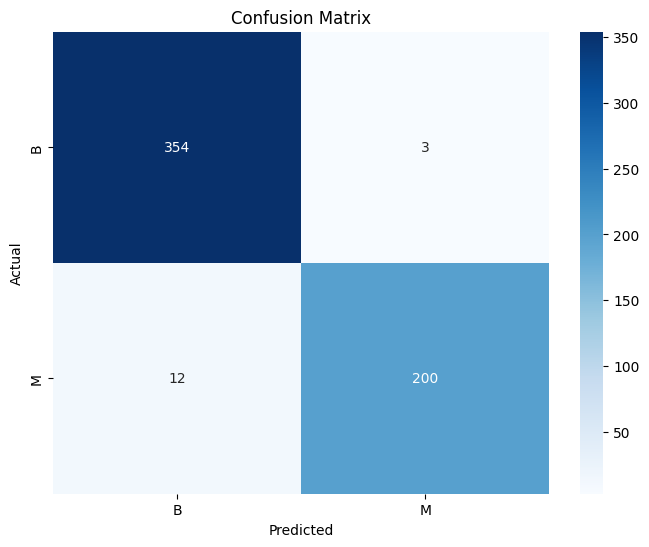

Classification Report:
              precision    recall  f1-score   support

           B       0.97      0.99      0.98       357
           M       0.99      0.94      0.96       212

    accuracy                           0.97       569
   macro avg       0.98      0.97      0.97       569
weighted avg       0.97      0.97      0.97       569



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# Data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

# Convert target variable to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.squeeze())

# Number of folds and random seed
num_folds = 10
seed = 7

# Define the k-fold cross-validator
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Prepare Logistic Regression model within a pipeline to avoid data leakage
logistic_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)), 
    ('classifier', LogisticRegression(solver='liblinear', C=0.1, penalty='l2'))
])

# Evaluate the model using cross-validation
scoring = 'accuracy'
cv_results = cross_val_score(logistic_regression_pipeline, X, y, cv=kfold, scoring=scoring)

# Print cross-validation results
print("Logistic Regression: %f (%f)" % (cv_results.mean(), cv_results.std()))

# Create a DataFrame to display the cross-validation results
results_df = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Mean Accuracy': [cv_results.mean()],
    'Standard Deviation': [cv_results.std()]
})
# Fit the model on the training data
logistic_regression_pipeline.fit(X, y)
y_pred = logistic_regression_pipeline.predict(X)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=label_encoder.classes_))


According to the Confusion Matrix the model predicted correctly positive and negative cases, showing minimal error in false negatives and positives.

- True Positives (TP) were 354.
- True Negatives (TN) were 200
- False Positives (FP) were 3 and False Negatives (FN) were 12.

The high precision of 99% shows that the model has very few false positives, making it highly reliable in predicting positive cases. The high recall value underscores the model's ability to detect nearly all positive instances, with minimal false negatives. This balanced performance is reflected in the F1 Score, which combines both precision and recall into a single metric. Overall, these metrics confirm that the Logistic Regression model is performing very well on this dataset.